In [1]:
import logging
import threading
import pandas as pd  
import math
import dill
import numpy as np  
import matplotlib.pyplot as plt
import pydot
import seaborn as seabornInstance
import networkx
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import anomaly
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator, ui, base, bif
from iotfunctions.base import BaseTransformer
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.enginelog import EngineLogging
from iotfunctions import pipeline as pp
from iotfunctions.stages import DataWriterSqlAlchemy, DataWriterFile
from iotfunctions.pipeline import JobController, DataAggregator

import datetime as dt
from scipy.linalg import norm
import scipy as sp
from scipy import signal
from scipy import linalg
from pyod.models.cblof import CBLOF
from pyod.models.ocsvm import OCSVM
from pyod.models.xgbod import XGBOD

#import pmdarima as pm
import inverse_covariance as icov # from package skggm
from inverse_covariance import QuicGraphLasso

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from skimage import util as skiutil # for nifty windowing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1599: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'
Using TensorFlow backend.
/home/markus/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/markus/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/markus/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:51

In [2]:

# copied from https://github.com/y-bar/ml-based-anomaly-detection
#   remove the boring part from an image resp. time series

def series_filter(values, kernel_size=3):
    """
    Filter a time series. Practically, calculated mean value inside kernel size.
    As math formula, see https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html.
    :param values:
    :param kernel_size:
    :return: The list of filtered average
    """
    filter_values = np.cumsum(values, dtype=float)

    filter_values[kernel_size:] = filter_values[kernel_size:] - filter_values[:-kernel_size]
    filter_values[kernel_size:] = filter_values[kernel_size:] / kernel_size

    for i in range(1, kernel_size):
        filter_values[i] /= i + 1

    return filter_values


def extrapolate_next(values):
    """
    Extrapolates the next value by sum up the slope of the last value with previous values.
    :param values: a list or numpy array of time-series
    :return: the next value of time-series
    """

    last_value = values[-1]
    slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
    slope[0] = 0
    next_values = last_value + np.cumsum(slope)

    return next_values


def marge_series(values, extend_num=5, forward=5):

    next_value = extrapolate_next(values)[forward]
    extension = [next_value] * extend_num

    if isinstance(values, list):
        marge_values = values + extension
    else:
        marge_values = np.append(values, extension)
    return marge_values



class Saliency(object):
    def __init__(self, amp_window_size, series_window_size, score_window_size):
        self.amp_window_size = amp_window_size
        self.series_window_size = series_window_size
        self.score_window_size = score_window_size

    def transform_saliency_map(self, values):
        """
        Transform a time-series into spectral residual, which is method in computer vision.
        For example, See https://github.com/uoip/SpectralResidualSaliency.
        :param values: a list or numpy array of float values.
        :return: silency map and spectral residual
        """

        freq = np.fft.fft(values)
        mag = np.sqrt(freq.real ** 2 + freq.imag ** 2)
        spectral_residual = np.exp(np.log(mag) - series_filter(np.log(mag), self.amp_window_size))

        freq.real = freq.real * spectral_residual / mag
        freq.imag = freq.imag * spectral_residual / mag

        silency_map = np.fft.ifft(freq)
        return silency_map

    def transform_spectral_residual(self, values):
        saliency_map = self.transform_saliency_map(values)
        spectral_residual = np.sqrt(saliency_map.real ** 2 + saliency_map.imag ** 2)
        return spectral_residual


In [3]:
# Get stuff in
df_input = pd.read_csv('./Issue-603-Temperature.csv',
                  parse_dates=['timestamp'])

# and sort it by timestamp
df_input = df_input.sort_values(by='timestamp')

df_input.head(3)

,deviceid,TEMPERATURE,timestamp
0,A101,70.522660,2019-11-24 15:43:00
1,A101,71.719810,2019-11-24 15:48:00
2,A101,72.840277,2019-11-24 15:53:00


In [4]:
# start with a single sensor
df_temp = df_input[(df_input.deviceid == 'A101')][['timestamp','TEMPERATURE']]

time_raw = df_temp['timestamp'].values
#temp_raw = df_temp['TEMPERATURE'].values
# turn timestamp into the index
df_temp = df_temp.set_index('timestamp')

#time_raw = df_temp['EVT_TIMESTAMP'].values
temp_raw = df_temp['TEMPERATURE'].values

# fill out the time gaps by backward filling - 2nd order splines are overkill I guess
def custom_resampler(array_like):
    if (array_like.values.size > 0):
        return array_like.values[0]
    return np.nan

upsampledna = df_temp.resample('5min').apply(custom_resampler)
upsampledna['RAW_TEMPERATURE'] = upsampledna['TEMPERATURE']
upsampled = df_temp.resample('5min').bfill()

df_temp = upsampled.interpolate(method='spline',order=2)
temp_sauber = df_temp['TEMPERATURE'].values

# double the flatline size (from 4 to 8 to 12 datapoints)
temp_flatline = np.insert(temp_sauber, 130, [32.99295068, 32.99295068, 32.99295068, 32.99295068])
temp_flatterline = np.insert(temp_flatline, 130, [32.99295068, 32.99295068, 32.99295068, 32.99295068])

dtemp_sauber = np.gradient(temp_sauber)

temp_sauber[130]

32.99295068

Text(0, 0.5, 'Temperature')

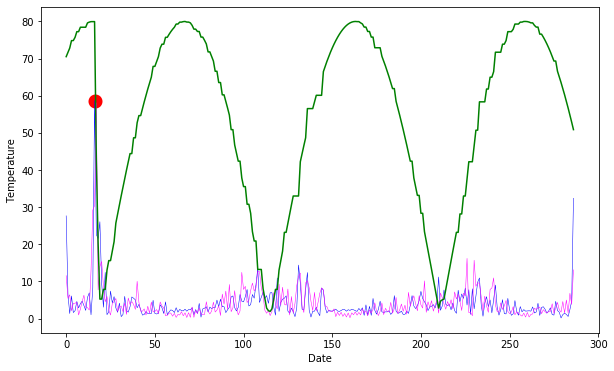

In [5]:
saliency = Saliency(12, 0, 0)
temp_sal = saliency.transform_spectral_residual(temp_sauber)
dtemp_sal = saliency.transform_spectral_residual(dtemp_sauber)

temp_sal *= 80
temp_sal_high = temp_sal.copy()
temp_sal_high[temp_sal_high < 40] = np.nan
x_axis = np.arange(0,temp_sal.size,1)

dtemp_sal *= 80

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(temp_sal, lw=0.5, color='blue')
ax.scatter(x_axis, temp_sal_high, lw=8, color='red')

#ax.plot(dtemp_sauber, lw=1.5, color='magenta')

ax.plot(dtemp_sal, lw=0.5, color='fuchsia')

ax.plot(temp_sauber, lw=1.5, color='green')
#ax.set_ylim(20, 120)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')

In [11]:
rate = 1
MS = 12


freqsTS, timesTS, SxTS = signal.spectrogram(temp_sauber, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - 1,
                                      detrend=False, scaling='spectrum')
freqsTS[freqsTS * MS < 2] = 0

freqsTSf, timesTSf, SxTSf = signal.spectrogram(temp_flatline, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - 1,
                                      detrend=False, scaling='spectrum')
freqsTSf[freqsTSf * MS < 2] = 0

freqsTSff, timesTSff, SxTSff = signal.spectrogram(temp_flatterline, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - 1,
                                      detrend=False, scaling='spectrum')
freqsTSff[freqsTSff * MS < 2] = 0

Mshort = 8
freqsTSfs, timesTSfs, SxTSfs = signal.spectrogram(temp_flatline, fs=rate, window='hanning',
                                      nperseg=Mshort, noverlap=Mshort - 1,
                                      detrend=False, scaling='spectrum')
freqsTSfs[freqsTSfs * Mshort < 2] = 0

Minsanelyshort = 6
freqsTSfis, timesTSfis, SxTSfis = signal.spectrogram(temp_flatline, fs=rate, window='hanning',
                                      nperseg=Minsanelyshort, noverlap=Minsanelyshort - 1,
                                      detrend=False, scaling='spectrum')
freqsTSfis[freqsTSfis * Minsanelyshort < 2] = 0

freqsTSfss, timesTSfss, SxTSfss = signal.spectrogram(temp_sauber, fs=rate, window='hanning',
                                      nperseg=Minsanelyshort, noverlap=Minsanelyshort - 1,
                                      detrend=False, scaling='spectrum')
freqsTSfss[freqsTSfss * Minsanelyshort < 2] = 0

SxTSfs[SxTSfs == 0] = 0.0001
SxTSfis[SxTSfis == 0] = 0.0001


freqsTSfss


array([0.        , 0.        , 0.33333333, 0.5       ])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


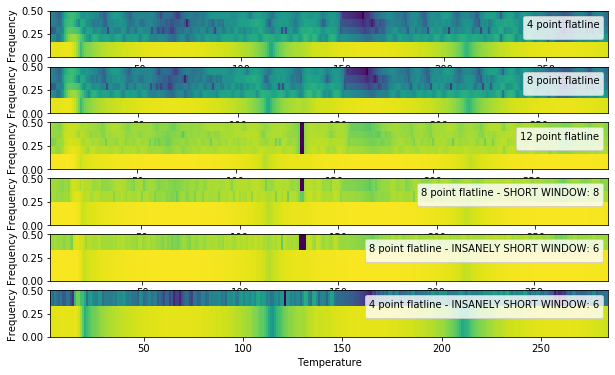

In [12]:
f, ax = plt.subplots(6,1,figsize=(10,6))
ax[0].pcolormesh(timesTS, freqsTS, 10 * np.log10(SxTS)) #, cmap='coolwarm')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Temperature')
ax[0].legend(title='4 point flatline')

ax[1].pcolormesh(timesTSf, freqsTSf, 10 * np.log10(SxTSf)) #, cmap='coolwarm')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Temperature')
ax[1].legend(title='8 point flatline')

ax[2].pcolormesh(timesTSff, freqsTSff, 10 * np.log10(SxTSff)) #, cmap='coolwarm')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Temperature')
ax[2].legend(title='12 point flatline')

ax[3].pcolormesh(timesTSfs, freqsTSfs, 10 * np.log10(SxTSfs)) #, cmap='coolwarm')
ax[3].set_ylabel('Frequency')
ax[3].set_xlabel('Temperature')
ax[3].legend(title='8 point flatline - SHORT WINDOW: ' + str(Mshort))

ax[4].pcolormesh(timesTSfis, freqsTSfis, 10 * np.log10(SxTSfis)) #, cmap='coolwarm')
ax[4].set_ylabel('Frequency')
ax[4].set_xlabel('Temperature')
ax[4].legend(title='8 point flatline - INSANELY SHORT WINDOW: ' + str(Minsanelyshort))

ax[5].pcolormesh(timesTSfss, freqsTSfss, 10 * np.log10(SxTSfss)) #, cmap='coolwarm')
ax[5].set_ylabel('Frequency')
ax[5].set_xlabel('Temperature')
ax[5].legend(title='4 point flatline - INSANELY SHORT WINDOW: ' + str(Minsanelyshort))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


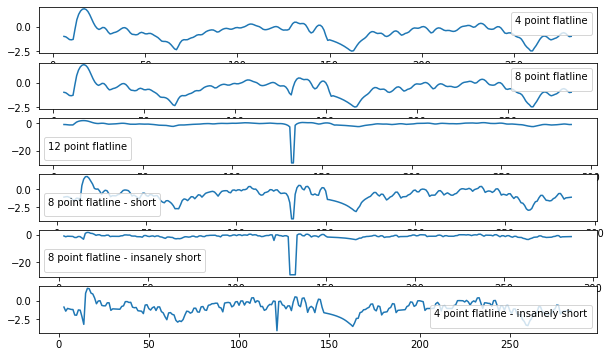

In [13]:
# Signal energy plots
ETS = np.log10(np.dot(SxTS.T, freqsTS))
ETSf = np.log10(np.dot(SxTSf.T, freqsTSf))
ETSff = np.log10(np.dot(SxTSff.T, freqsTSff))
ETSfs = np.log10(np.dot(SxTSfs.T, freqsTSfs))
ETSfis = np.log10(np.dot(SxTSfis.T, freqsTSfis))
ETSfss = np.log10(np.dot(SxTSfss.T, freqsTSfss))

f, ax = plt.subplots(6,1,figsize=(10,6))
ax[0].plot(timesTS, ETS) #, cmap='coolwarm')
ax[0].legend(title='4 point flatline')

ax[1].plot(timesTSf, ETSf) #, cmap='coolwarm')
ax[1].legend(title='8 point flatline')

ax[2].plot(timesTSff, ETSff) #, cmap='coolwarm')
ax[2].legend(title='12 point flatline')

ax[3].plot(timesTSfs, ETSfs) #, cmap='coolwarm')
ax[3].legend(title='8 point flatline - short')

ax[4].plot(timesTSfis, ETSfis) #, cmap='coolwarm')
ax[4].legend(title='8 point flatline - insanely short')

ax[5].plot(timesTSfss, ETSfss) #, cmap='coolwarm')
ax[5].legend(title='4 point flatline - insanely short')


In [14]:
# run-length encoding - see
# https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                  # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(i, z, p, ia[i])



# cut is in slices and try to predict the last value
winsize = 12
slices = skiutil.view_as_windows(temp_sauber, window_shape=(winsize,))

Xl = []
# for prediction 
yl = []
# for anomaly classification
yyl = []
for slice in slices:
    Xl.append(slice[0:winsize-1])
    yl.append(slice[winsize-1:winsize])

    if rle(slice)[0].size < 7:
        print ('yes')
        yyl.append(1)
    else:
        yyl.append(0)
X = np.array(Xl)
y = np.array(yl)
yy = np.array(yyl)
y = np.reshape(y,(y.shape[0],))
yy = np.reshape(yy,(yy.shape[0],))

xshape = X.shape
n_steps= xshape[0]



yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [15]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
Xinput = X.reshape((X.shape[0], X.shape[1], n_features))
Xinput.shape
n_steps = Xinput.shape[1]

In [16]:
yy.dtype

dtype('int64')

In [35]:
# see
# https://jaai.de/convolutional-neural-networks-cnn-aufbau-funktion-und-anwendungsgebiete-1691/
#
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Flatten, Input, Dropout, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils import model_to_dot

opt = optimizers.Adam(0.001)

def get_model():
    inp = Input(shape=(11, 1))
    
    # 2x2 convolution
    img1 = Convolution1D(filters=64, kernel_size=2, activation='relu')(inp)
                #input_shape=(11,1))) # each input vector is 11 elements long and we look for a single feature
    
    # get the largest of the 4 matrices
    img2 = MaxPooling1D(pool_size=2)(img1)
    
    # flatten to an array
    img3 = Flatten()(img2)
    #img3 = GlobalMaxPooling1D()(img2)
    
    
    dense1 = Dense(50, activation='relu')(img3)
    
    #dense2 = Dense(1, activation=activations.softmax)(dense1)

    dense2 = Dense(1, activation=activations.relu)(dense1)
    
    model = models.Model(inputs=inp, outputs=dense2)
    
    # prediction
    model.compile(optimizer='adam', loss='mse')
    # anomaly classification
    #model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    
    model.summary()
    return model

In [36]:
model = get_model()

#plot_model(model, to_file='model.png')
iv1_dot = model_to_dot(model, show_shapes=False, show_layer_names=True) #, rankdir='LR')
iv1_dot.set_size('10x10')

#SVG(iv1_dot.create(prog=['dot'], format='svg'))
#plt.show()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 11, 1)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_______________________________________________________

In [37]:
# fit model
# this model parameter for prediction
model.fit(Xinput, y, epochs=200, validation_split=0.15, batch_size=8, verbose=1)

# this model for categorization
#model.fit(Xinput, yy, epochs=200, validation_split=0.15, batch_size=8, verbose=2)


Train on 234 samples, validate on 42 samples
Epoch 1/200
234/234 [==============================] - 0s 636us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 2/200
234/234 [==============================] - 0s 133us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 3/200
234/234 [==============================] - 0s 121us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 4/200
234/234 [==============================] - 0s 111us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 5/200
234/234 [==============================] - 0s 109us/step - loss: 3094.2653 - val_loss: 5306.4448
Epoch 6/200
234/234 [==============================] - 0s 111us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 7/200
234/234 [==============================] - 0s 114us/step - loss: 3094.2653 - val_loss: 5306.4448
Epoch 8/200
234/234 [==============================] - 0s 115us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 9/200
234/234 [==============================] - 0s 121us/step - loss: 3094.2

234/234 [==============================] - 0s 114us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 150/200
234/234 [==============================] - 0s 117us/step - loss: 3094.2653 - val_loss: 5306.4448
Epoch 151/200
234/234 [==============================] - 0s 107us/step - loss: 3094.2653 - val_loss: 5306.4448
Epoch 152/200
234/234 [==============================] - 0s 113us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 153/200
234/234 [==============================] - 0s 117us/step - loss: 3094.2653 - val_loss: 5306.4448
Epoch 154/200
234/234 [==============================] - 0s 119us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 155/200
234/234 [==============================] - 0s 112us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 156/200
234/234 [==============================] - 0s 112us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 157/200
234/234 [==============================] - 0s 117us/step - loss: 3094.2652 - val_loss: 5306.4448
Epoch 158/200
2

In [38]:
# predict
nn = 13
x_test = X[nn]
x_test = np.reshape(x_test, (1, n_steps, 1))
yhat = model.predict(x_test, verbose=0)
(x_test,y[nn], yhat)

(array([[[79.82266273],
         [79.95404596],
         [79.96030403],
         [79.96030403],
         [42.58386225],
         [20.22471354],
         [ 5.22827111],
         [ 5.22827111],
         [ 7.83541837],
         [ 7.83541837],
         [13.02180154]]]), 15.59549219, array([[0.]], dtype=float32))

In [42]:
# see
# https://jaai.de/convolutional-neural-networks-cnn-aufbau-funktion-und-anwendungsgebiete-1691/
#
opt = optimizers.Adam(0.0001)
#opt = optimizers.RMSprop(lr=1e-4)

def get_modelC():
    inp = Input(shape=(11, 1))
    
    # 2x2 convolution
    img1 = Convolution1D(filters=64, kernel_size=3, activation=activations.relu, padding='valid')(inp)
                #input_shape=(11,1))) # each input vector is 11 elements long and we look for a single feature
    
    # Dropout affects convergence negatively here
    #drop1 = Dropout(0.25)(img1)
    drop1 = img1
    
    img2 = Convolution1D(filters=16, kernel_size=2, activation=activations.relu, padding="valid")(drop1)

    # Dropout affects convergence negatively here
    #drop2 = Dropout(0.25)(img2)
    drop2 = img2
    
    # get the largest of the 4 matrices
    img3 = MaxPooling1D(pool_size=2)(drop2)
    
    # flatten to an array
    img4 = Flatten()(img3)
    
    dense1 = Dense(64, activation=activations.relu)(img4)
    #dense1 = Dense(64, activation=activations.relu)(inp)

    dense2 = Dense(1, activation=activations.sigmoid)(dense1)

    #dense2 = Dense(1, activation=activations.relu)(dense1)
    
    model = models.Model(inputs=inp, outputs=dense2)
    
    # prediction
    #model.compile(optimizer='adam', loss='mse')
    # anomaly classification
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['accuracy', 'binary_crossentropy'])
    
    model.summary()
    return model

In [43]:
modelC = get_modelC()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 11, 1)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 9, 64)             256       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 8, 16)             2064      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 16)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65  

In [46]:
# this model for categorization
history = modelC.fit(Xinput, yy, epochs=1200, validation_split=0.10, batch_size=8, verbose=1)


Train on 248 samples, validate on 28 samples
Epoch 1/1200
248/248 [==============================] - 0s 140us/step - loss: 0.2779 - accuracy: 0.8831 - binary_crossentropy: 0.2779 - val_loss: 0.2024 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2024
Epoch 2/1200
248/248 [==============================] - 0s 136us/step - loss: 0.2826 - accuracy: 0.8831 - binary_crossentropy: 0.2826 - val_loss: 0.2114 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2114
Epoch 3/1200
248/248 [==============================] - 0s 121us/step - loss: 0.2793 - accuracy: 0.8831 - binary_crossentropy: 0.2793 - val_loss: 0.2092 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2092
Epoch 4/1200
248/248 [==============================] - 0s 127us/step - loss: 0.2786 - accuracy: 0.8831 - binary_crossentropy: 0.2786 - val_loss: 0.2083 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2083
Epoch 5/1200
248/248 [==============================] - 0s 125us/step - loss: 0.2771 - accuracy: 0.8790 - binary_cr

Epoch 40/1200
248/248 [==============================] - 0s 129us/step - loss: 0.2761 - accuracy: 0.8831 - binary_crossentropy: 0.2761 - val_loss: 0.2087 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2087
Epoch 41/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2710 - accuracy: 0.8831 - binary_crossentropy: 0.2710 - val_loss: 0.2037 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2037
Epoch 42/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2809 - accuracy: 0.8831 - binary_crossentropy: 0.2809 - val_loss: 0.2187 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2187
Epoch 43/1200
248/248 [==============================] - 0s 128us/step - loss: 0.2794 - accuracy: 0.8831 - binary_crossentropy: 0.2794 - val_loss: 0.2122 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2122
Epoch 44/1200
248/248 [==============================] - 0s 130us/step - loss: 0.2882 - accuracy: 0.8831 - binary_crossentropy: 0.2882 - val_loss: 0.2048 - 

Epoch 79/1200
248/248 [==============================] - 0s 128us/step - loss: 0.2862 - accuracy: 0.8871 - binary_crossentropy: 0.2862 - val_loss: 0.2078 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2078
Epoch 80/1200
248/248 [==============================] - 0s 125us/step - loss: 0.2728 - accuracy: 0.8871 - binary_crossentropy: 0.2728 - val_loss: 0.2068 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2068
Epoch 81/1200
248/248 [==============================] - 0s 130us/step - loss: 0.2703 - accuracy: 0.8831 - binary_crossentropy: 0.2703 - val_loss: 0.2113 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2113
Epoch 82/1200
248/248 [==============================] - 0s 125us/step - loss: 0.2729 - accuracy: 0.8831 - binary_crossentropy: 0.2729 - val_loss: 0.2066 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2066
Epoch 83/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2776 - accuracy: 0.8831 - binary_crossentropy: 0.2776 - val_loss: 0.2057 - 

Epoch 118/1200
248/248 [==============================] - 0s 127us/step - loss: 0.2623 - accuracy: 0.8871 - binary_crossentropy: 0.2623 - val_loss: 0.2027 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2027
Epoch 119/1200
248/248 [==============================] - 0s 130us/step - loss: 0.2726 - accuracy: 0.8831 - binary_crossentropy: 0.2726 - val_loss: 0.2135 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2135
Epoch 120/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2865 - accuracy: 0.8710 - binary_crossentropy: 0.2865 - val_loss: 0.2263 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2263
Epoch 121/1200
248/248 [==============================] - 0s 127us/step - loss: 0.2741 - accuracy: 0.8831 - binary_crossentropy: 0.2741 - val_loss: 0.2257 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2257
Epoch 122/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2638 - accuracy: 0.8831 - binary_crossentropy: 0.2638 - val_loss: 0.22

Epoch 157/1200
248/248 [==============================] - 0s 127us/step - loss: 0.2654 - accuracy: 0.8831 - binary_crossentropy: 0.2654 - val_loss: 0.2077 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2077
Epoch 158/1200
248/248 [==============================] - 0s 128us/step - loss: 0.2622 - accuracy: 0.8790 - binary_crossentropy: 0.2622 - val_loss: 0.2022 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2022
Epoch 159/1200
248/248 [==============================] - 0s 127us/step - loss: 0.2667 - accuracy: 0.8831 - binary_crossentropy: 0.2667 - val_loss: 0.2028 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2028
Epoch 160/1200
248/248 [==============================] - 0s 129us/step - loss: 0.2662 - accuracy: 0.8790 - binary_crossentropy: 0.2662 - val_loss: 0.2124 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2124
Epoch 161/1200
248/248 [==============================] - 0s 130us/step - loss: 0.2586 - accuracy: 0.8871 - binary_crossentropy: 0.2586 - val_loss: 0.20

Epoch 196/1200
248/248 [==============================] - 0s 127us/step - loss: 0.2691 - accuracy: 0.8831 - binary_crossentropy: 0.2691 - val_loss: 0.2026 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2026
Epoch 197/1200
248/248 [==============================] - 0s 128us/step - loss: 0.2681 - accuracy: 0.8710 - binary_crossentropy: 0.2681 - val_loss: 0.2112 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2112
Epoch 198/1200
248/248 [==============================] - 0s 125us/step - loss: 0.2684 - accuracy: 0.8790 - binary_crossentropy: 0.2684 - val_loss: 0.2319 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2319
Epoch 199/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2534 - accuracy: 0.8871 - binary_crossentropy: 0.2534 - val_loss: 0.2129 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2129
Epoch 200/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2640 - accuracy: 0.8831 - binary_crossentropy: 0.2640 - val_loss: 0.21

Epoch 235/1200
248/248 [==============================] - 0s 128us/step - loss: 0.2564 - accuracy: 0.8871 - binary_crossentropy: 0.2564 - val_loss: 0.2375 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2375
Epoch 236/1200
248/248 [==============================] - 0s 130us/step - loss: 0.2544 - accuracy: 0.8871 - binary_crossentropy: 0.2544 - val_loss: 0.2134 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2134
Epoch 237/1200
248/248 [==============================] - 0s 126us/step - loss: 0.2881 - accuracy: 0.8831 - binary_crossentropy: 0.2881 - val_loss: 0.2221 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2221
Epoch 238/1200
248/248 [==============================] - 0s 126us/step - loss: 0.2494 - accuracy: 0.8911 - binary_crossentropy: 0.2494 - val_loss: 0.2213 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2213
Epoch 239/1200
248/248 [==============================] - 0s 128us/step - loss: 0.2568 - accuracy: 0.8952 - binary_crossentropy: 0.2568 - val_loss: 0.21

Epoch 274/1200
248/248 [==============================] - 0s 127us/step - loss: 0.2660 - accuracy: 0.8992 - binary_crossentropy: 0.2660 - val_loss: 0.2127 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2127
Epoch 275/1200
248/248 [==============================] - 0s 121us/step - loss: 0.2448 - accuracy: 0.8992 - binary_crossentropy: 0.2448 - val_loss: 0.2107 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2107
Epoch 276/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2463 - accuracy: 0.8871 - binary_crossentropy: 0.2463 - val_loss: 0.2074 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2074
Epoch 277/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2586 - accuracy: 0.8831 - binary_crossentropy: 0.2586 - val_loss: 0.2210 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2210
Epoch 278/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2629 - accuracy: 0.8831 - binary_crossentropy: 0.2629 - val_loss: 0.22

Epoch 313/1200
248/248 [==============================] - 0s 129us/step - loss: 0.2476 - accuracy: 0.8871 - binary_crossentropy: 0.2476 - val_loss: 0.2339 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2339
Epoch 314/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2406 - accuracy: 0.8911 - binary_crossentropy: 0.2406 - val_loss: 0.2176 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2176
Epoch 315/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2421 - accuracy: 0.8911 - binary_crossentropy: 0.2421 - val_loss: 0.2378 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2378
Epoch 316/1200
248/248 [==============================] - 0s 116us/step - loss: 0.2530 - accuracy: 0.8992 - binary_crossentropy: 0.2530 - val_loss: 0.2164 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2164
Epoch 317/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2426 - accuracy: 0.8992 - binary_crossentropy: 0.2426 - val_loss: 0.23

Epoch 352/1200
248/248 [==============================] - 0s 132us/step - loss: 0.2533 - accuracy: 0.8871 - binary_crossentropy: 0.2533 - val_loss: 0.2138 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2138
Epoch 353/1200
248/248 [==============================] - 0s 130us/step - loss: 0.2416 - accuracy: 0.8952 - binary_crossentropy: 0.2416 - val_loss: 0.2241 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2241
Epoch 354/1200
248/248 [==============================] - 0s 132us/step - loss: 0.2390 - accuracy: 0.8911 - binary_crossentropy: 0.2390 - val_loss: 0.2178 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2178
Epoch 355/1200
248/248 [==============================] - 0s 133us/step - loss: 0.2429 - accuracy: 0.8952 - binary_crossentropy: 0.2429 - val_loss: 0.2178 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2178
Epoch 356/1200
248/248 [==============================] - 0s 135us/step - loss: 0.2427 - accuracy: 0.8710 - binary_crossentropy: 0.2427 - val_loss: 0.22

Epoch 391/1200
248/248 [==============================] - 0s 134us/step - loss: 0.2295 - accuracy: 0.8992 - binary_crossentropy: 0.2295 - val_loss: 0.2151 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2151
Epoch 392/1200
248/248 [==============================] - 0s 138us/step - loss: 0.2347 - accuracy: 0.9073 - binary_crossentropy: 0.2347 - val_loss: 0.2174 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2174
Epoch 393/1200
248/248 [==============================] - 0s 129us/step - loss: 0.2325 - accuracy: 0.9032 - binary_crossentropy: 0.2325 - val_loss: 0.2147 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2147
Epoch 394/1200
248/248 [==============================] - 0s 130us/step - loss: 0.2281 - accuracy: 0.8952 - binary_crossentropy: 0.2281 - val_loss: 0.2202 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2202
Epoch 395/1200
248/248 [==============================] - 0s 134us/step - loss: 0.2380 - accuracy: 0.8952 - binary_crossentropy: 0.2380 - val_loss: 0.23

Epoch 430/1200
248/248 [==============================] - 0s 126us/step - loss: 0.2216 - accuracy: 0.8992 - binary_crossentropy: 0.2216 - val_loss: 0.2208 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2208
Epoch 431/1200
248/248 [==============================] - 0s 121us/step - loss: 0.2331 - accuracy: 0.8911 - binary_crossentropy: 0.2331 - val_loss: 0.2222 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2222
Epoch 432/1200
248/248 [==============================] - 0s 120us/step - loss: 0.2345 - accuracy: 0.9032 - binary_crossentropy: 0.2345 - val_loss: 0.2246 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2246
Epoch 433/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2280 - accuracy: 0.8911 - binary_crossentropy: 0.2280 - val_loss: 0.2156 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2156
Epoch 434/1200
248/248 [==============================] - 0s 119us/step - loss: 0.2307 - accuracy: 0.9073 - binary_crossentropy: 0.2307 - val_loss: 0.23

Epoch 469/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2217 - accuracy: 0.8952 - binary_crossentropy: 0.2217 - val_loss: 0.2231 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2231
Epoch 470/1200
248/248 [==============================] - 0s 126us/step - loss: 0.2133 - accuracy: 0.9153 - binary_crossentropy: 0.2133 - val_loss: 0.2434 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2434
Epoch 471/1200
248/248 [==============================] - 0s 120us/step - loss: 0.2210 - accuracy: 0.9113 - binary_crossentropy: 0.2210 - val_loss: 0.2406 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2406
Epoch 472/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2303 - accuracy: 0.8952 - binary_crossentropy: 0.2303 - val_loss: 0.2233 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2233
Epoch 473/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2308 - accuracy: 0.8992 - binary_crossentropy: 0.2308 - val_loss: 0.24

Epoch 508/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2121 - accuracy: 0.9073 - binary_crossentropy: 0.2121 - val_loss: 0.2210 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2210
Epoch 509/1200
248/248 [==============================] - 0s 125us/step - loss: 0.2158 - accuracy: 0.9315 - binary_crossentropy: 0.2158 - val_loss: 0.2301 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2301
Epoch 510/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2116 - accuracy: 0.9274 - binary_crossentropy: 0.2116 - val_loss: 0.2343 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2343
Epoch 511/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2084 - accuracy: 0.9153 - binary_crossentropy: 0.2084 - val_loss: 0.2285 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2285
Epoch 512/1200
248/248 [==============================] - 0s 119us/step - loss: 0.2020 - accuracy: 0.9274 - binary_crossentropy: 0.2020 - val_loss: 0.23

Epoch 547/1200
248/248 [==============================] - 0s 126us/step - loss: 0.2041 - accuracy: 0.9274 - binary_crossentropy: 0.2041 - val_loss: 0.2262 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2262
Epoch 548/1200
248/248 [==============================] - 0s 126us/step - loss: 0.1965 - accuracy: 0.9355 - binary_crossentropy: 0.1965 - val_loss: 0.2457 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2457
Epoch 549/1200
248/248 [==============================] - 0s 118us/step - loss: 0.2245 - accuracy: 0.8992 - binary_crossentropy: 0.2245 - val_loss: 0.2257 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2257
Epoch 550/1200
248/248 [==============================] - 0s 116us/step - loss: 0.2070 - accuracy: 0.9073 - binary_crossentropy: 0.2070 - val_loss: 0.2422 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2422
Epoch 551/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2017 - accuracy: 0.9194 - binary_crossentropy: 0.2017 - val_loss: 0.23

Epoch 586/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2056 - accuracy: 0.9073 - binary_crossentropy: 0.2056 - val_loss: 0.2294 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2294
Epoch 587/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2101 - accuracy: 0.9234 - binary_crossentropy: 0.2101 - val_loss: 0.2333 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2333
Epoch 588/1200
248/248 [==============================] - 0s 116us/step - loss: 0.2149 - accuracy: 0.9073 - binary_crossentropy: 0.2149 - val_loss: 0.2314 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2314
Epoch 589/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2194 - accuracy: 0.9194 - binary_crossentropy: 0.2194 - val_loss: 0.2174 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2174
Epoch 590/1200
248/248 [==============================] - 0s 123us/step - loss: 0.2016 - accuracy: 0.9113 - binary_crossentropy: 0.2016 - val_loss: 0.22

Epoch 625/1200
248/248 [==============================] - 0s 128us/step - loss: 0.2021 - accuracy: 0.9274 - binary_crossentropy: 0.2021 - val_loss: 0.2405 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2405
Epoch 626/1200
248/248 [==============================] - 0s 125us/step - loss: 0.1968 - accuracy: 0.9113 - binary_crossentropy: 0.1968 - val_loss: 0.2495 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2495
Epoch 627/1200
248/248 [==============================] - 0s 133us/step - loss: 0.2109 - accuracy: 0.9153 - binary_crossentropy: 0.2109 - val_loss: 0.2292 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2292
Epoch 628/1200
248/248 [==============================] - 0s 130us/step - loss: 0.1893 - accuracy: 0.9315 - binary_crossentropy: 0.1893 - val_loss: 0.2395 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2395
Epoch 629/1200
248/248 [==============================] - 0s 120us/step - loss: 0.1944 - accuracy: 0.9234 - binary_crossentropy: 0.1944 - val_loss: 0.24

Epoch 664/1200
248/248 [==============================] - 0s 121us/step - loss: 0.1857 - accuracy: 0.9395 - binary_crossentropy: 0.1857 - val_loss: 0.2434 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2434
Epoch 665/1200
248/248 [==============================] - 0s 115us/step - loss: 0.1741 - accuracy: 0.9435 - binary_crossentropy: 0.1741 - val_loss: 0.2249 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2249
Epoch 666/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2023 - accuracy: 0.9194 - binary_crossentropy: 0.2023 - val_loss: 0.2469 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2469
Epoch 667/1200
248/248 [==============================] - 0s 125us/step - loss: 0.2033 - accuracy: 0.9315 - binary_crossentropy: 0.2033 - val_loss: 0.2432 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2432
Epoch 668/1200
248/248 [==============================] - 0s 125us/step - loss: 0.2019 - accuracy: 0.9113 - binary_crossentropy: 0.2019 - val_loss: 0.26

Epoch 703/1200
248/248 [==============================] - 0s 129us/step - loss: 0.1713 - accuracy: 0.9476 - binary_crossentropy: 0.1713 - val_loss: 0.2481 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2481
Epoch 704/1200
248/248 [==============================] - 0s 125us/step - loss: 0.1782 - accuracy: 0.9234 - binary_crossentropy: 0.1782 - val_loss: 0.2557 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2557
Epoch 705/1200
248/248 [==============================] - 0s 127us/step - loss: 0.1759 - accuracy: 0.9395 - binary_crossentropy: 0.1759 - val_loss: 0.2555 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2555
Epoch 706/1200
248/248 [==============================] - 0s 124us/step - loss: 0.2000 - accuracy: 0.9315 - binary_crossentropy: 0.2000 - val_loss: 0.2460 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2460
Epoch 707/1200
248/248 [==============================] - 0s 126us/step - loss: 0.1767 - accuracy: 0.9435 - binary_crossentropy: 0.1767 - val_loss: 0.26

Epoch 742/1200
248/248 [==============================] - 0s 127us/step - loss: 0.1777 - accuracy: 0.9234 - binary_crossentropy: 0.1777 - val_loss: 0.2334 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2334
Epoch 743/1200
248/248 [==============================] - 0s 123us/step - loss: 0.1882 - accuracy: 0.9113 - binary_crossentropy: 0.1882 - val_loss: 0.2419 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2419
Epoch 744/1200
248/248 [==============================] - 0s 132us/step - loss: 0.1702 - accuracy: 0.9355 - binary_crossentropy: 0.1702 - val_loss: 0.2216 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2216
Epoch 745/1200
248/248 [==============================] - 0s 131us/step - loss: 0.1802 - accuracy: 0.9153 - binary_crossentropy: 0.1802 - val_loss: 0.2394 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2394
Epoch 746/1200
248/248 [==============================] - 0s 124us/step - loss: 0.1740 - accuracy: 0.9395 - binary_crossentropy: 0.1740 - val_loss: 0.23

Epoch 781/1200
248/248 [==============================] - 0s 122us/step - loss: 0.1518 - accuracy: 0.9516 - binary_crossentropy: 0.1518 - val_loss: 0.2417 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2417
Epoch 782/1200
248/248 [==============================] - 0s 123us/step - loss: 0.1668 - accuracy: 0.9476 - binary_crossentropy: 0.1668 - val_loss: 0.2757 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2757
Epoch 783/1200
248/248 [==============================] - 0s 123us/step - loss: 0.1875 - accuracy: 0.9073 - binary_crossentropy: 0.1875 - val_loss: 0.2230 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2230
Epoch 784/1200
248/248 [==============================] - 0s 119us/step - loss: 0.2124 - accuracy: 0.9073 - binary_crossentropy: 0.2124 - val_loss: 0.3146 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.3146
Epoch 785/1200
248/248 [==============================] - 0s 123us/step - loss: 0.1664 - accuracy: 0.9395 - binary_crossentropy: 0.1664 - val_loss: 0.26

Epoch 819/1200
248/248 [==============================] - 0s 128us/step - loss: 0.1669 - accuracy: 0.9355 - binary_crossentropy: 0.1669 - val_loss: 0.2556 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2556
Epoch 820/1200
248/248 [==============================] - 0s 121us/step - loss: 0.1535 - accuracy: 0.9516 - binary_crossentropy: 0.1535 - val_loss: 0.2467 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2467
Epoch 821/1200
248/248 [==============================] - 0s 123us/step - loss: 0.1546 - accuracy: 0.9476 - binary_crossentropy: 0.1546 - val_loss: 0.2702 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2702
Epoch 822/1200
248/248 [==============================] - 0s 120us/step - loss: 0.1539 - accuracy: 0.9395 - binary_crossentropy: 0.1539 - val_loss: 0.3039 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.3039
Epoch 823/1200
248/248 [==============================] - 0s 122us/step - loss: 0.2055 - accuracy: 0.8992 - binary_crossentropy: 0.2055 - val_loss: 0.24

Epoch 858/1200
248/248 [==============================] - 0s 125us/step - loss: 0.1417 - accuracy: 0.9435 - binary_crossentropy: 0.1417 - val_loss: 0.2139 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2139
Epoch 859/1200
248/248 [==============================] - 0s 128us/step - loss: 0.1554 - accuracy: 0.9435 - binary_crossentropy: 0.1554 - val_loss: 0.2833 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2833
Epoch 860/1200
248/248 [==============================] - 0s 128us/step - loss: 0.1788 - accuracy: 0.9234 - binary_crossentropy: 0.1788 - val_loss: 0.2264 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2264
Epoch 861/1200
248/248 [==============================] - 0s 123us/step - loss: 0.1483 - accuracy: 0.9516 - binary_crossentropy: 0.1483 - val_loss: 0.2740 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2740
Epoch 862/1200
248/248 [==============================] - 0s 124us/step - loss: 0.1455 - accuracy: 0.9435 - binary_crossentropy: 0.1455 - val_loss: 0.23

Epoch 897/1200
248/248 [==============================] - 0s 124us/step - loss: 0.1518 - accuracy: 0.9476 - binary_crossentropy: 0.1518 - val_loss: 0.2413 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2413
Epoch 898/1200
248/248 [==============================] - 0s 122us/step - loss: 0.1611 - accuracy: 0.9355 - binary_crossentropy: 0.1611 - val_loss: 0.2562 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2562
Epoch 899/1200
248/248 [==============================] - 0s 127us/step - loss: 0.1382 - accuracy: 0.9516 - binary_crossentropy: 0.1382 - val_loss: 0.2469 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2469
Epoch 900/1200
248/248 [==============================] - 0s 126us/step - loss: 0.1303 - accuracy: 0.9556 - binary_crossentropy: 0.1303 - val_loss: 0.2676 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2676
Epoch 901/1200
248/248 [==============================] - 0s 130us/step - loss: 0.1361 - accuracy: 0.9516 - binary_crossentropy: 0.1361 - val_loss: 0.28

Epoch 936/1200
248/248 [==============================] - 0s 128us/step - loss: 0.1344 - accuracy: 0.9355 - binary_crossentropy: 0.1344 - val_loss: 0.3290 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.3290
Epoch 937/1200
248/248 [==============================] - 0s 122us/step - loss: 0.1628 - accuracy: 0.9476 - binary_crossentropy: 0.1628 - val_loss: 0.2463 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2463
Epoch 938/1200
248/248 [==============================] - 0s 122us/step - loss: 0.1315 - accuracy: 0.9516 - binary_crossentropy: 0.1315 - val_loss: 0.2499 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2499
Epoch 939/1200
248/248 [==============================] - 0s 120us/step - loss: 0.1360 - accuracy: 0.9516 - binary_crossentropy: 0.1360 - val_loss: 0.2468 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2468
Epoch 940/1200
248/248 [==============================] - 0s 121us/step - loss: 0.1289 - accuracy: 0.9395 - binary_crossentropy: 0.1289 - val_loss: 0.32

Epoch 1013/1200
248/248 [==============================] - 0s 143us/step - loss: 0.1262 - accuracy: 0.9556 - binary_crossentropy: 0.1262 - val_loss: 0.2354 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2354
Epoch 1014/1200
248/248 [==============================] - 0s 145us/step - loss: 0.1222 - accuracy: 0.9677 - binary_crossentropy: 0.1222 - val_loss: 0.2662 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2662
Epoch 1015/1200
248/248 [==============================] - 0s 145us/step - loss: 0.1203 - accuracy: 0.9597 - binary_crossentropy: 0.1203 - val_loss: 0.2685 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2685
Epoch 1016/1200
248/248 [==============================] - 0s 148us/step - loss: 0.1288 - accuracy: 0.9435 - binary_crossentropy: 0.1288 - val_loss: 0.2560 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2560
Epoch 1017/1200
248/248 [==============================] - 0s 148us/step - loss: 0.1127 - accuracy: 0.9556 - binary_crossentropy: 0.1127 - val_loss:

248/248 [==============================] - 0s 119us/step - loss: 0.1252 - accuracy: 0.9516 - binary_crossentropy: 0.1252 - val_loss: 0.3073 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.3073
Epoch 1090/1200
248/248 [==============================] - 0s 121us/step - loss: 0.1168 - accuracy: 0.9516 - binary_crossentropy: 0.1168 - val_loss: 0.2542 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2542
Epoch 1091/1200
248/248 [==============================] - 0s 122us/step - loss: 0.1147 - accuracy: 0.9677 - binary_crossentropy: 0.1147 - val_loss: 0.2403 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2403
Epoch 1092/1200
248/248 [==============================] - 0s 119us/step - loss: 0.1350 - accuracy: 0.9556 - binary_crossentropy: 0.1350 - val_loss: 0.2509 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2509
Epoch 1093/1200
248/248 [==============================] - 0s 122us/step - loss: 0.1204 - accuracy: 0.9677 - binary_crossentropy: 0.1204 - val_loss: 0.2976 - val_ac

248/248 [==============================] - 0s 126us/step - loss: 0.1067 - accuracy: 0.9677 - binary_crossentropy: 0.1067 - val_loss: 0.2816 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2816
Epoch 1166/1200
248/248 [==============================] - 0s 124us/step - loss: 0.1005 - accuracy: 0.9677 - binary_crossentropy: 0.1005 - val_loss: 0.2499 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2499
Epoch 1167/1200
248/248 [==============================] - 0s 123us/step - loss: 0.1647 - accuracy: 0.9395 - binary_crossentropy: 0.1647 - val_loss: 0.2501 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2501
Epoch 1168/1200
248/248 [==============================] - 0s 126us/step - loss: 0.1177 - accuracy: 0.9476 - binary_crossentropy: 0.1177 - val_loss: 0.2596 - val_accuracy: 0.9286 - val_binary_crossentropy: 0.2596
Epoch 1169/1200
248/248 [==============================] - 0s 125us/step - loss: 0.1075 - accuracy: 0.9597 - binary_crossentropy: 0.1075 - val_loss: 0.3537 - val_ac

In [47]:
nn = 130
x_test = X[nn]
yy_test = yy[nn]
x_test = np.reshape(x_test, (1, n_steps, 1))
yhat = modelC.predict(x_test, verbose=0)
yhat = yhat[0][0]
(x_test,yy[nn], yhat)

(array([[[32.99295068],
         [32.99295068],
         [42.21663977],
         [44.41577289],
         [46.5674169 ],
         [48.66927128],
         [56.53469515],
         [56.53469515],
         [56.53469515],
         [56.53469515],
         [58.35503949]]]), 0, 0.012370891)

In [50]:
time_sauber = np.arange(0, X.shape[0])
time_sauber.shape

predl = []
for i in range(X.shape[0]):
    x_test = np.reshape(X[i], (1, n_steps, 1))
    predl.append(modelC.predict(x_test, verbose=0)[0][0])

pred = np.array(predl)
print (pred.max())
pred[pred < 0.5] = 0
pred[pred > 0] = 55
pred[pred == 0] = np.nan



0.9686149


No handles with labels found to put in legend.


Text(0, -2.4, 'label')

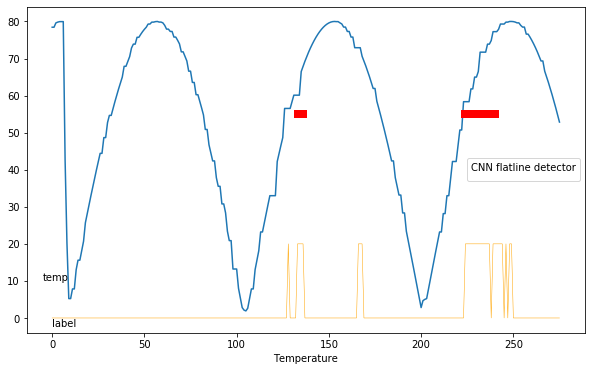

In [51]:

f, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(time_sauber, X[:,10]) #, cmap='coolwarm')
ax.text(-5,10, 'temp')
ax.set_xlabel('Temperature')
ax.legend(title='CNN flatline detector')
ax.plot(time_sauber, pred, lw=8, color='red')
ax.plot(time_sauber, yy*20, lw=0.5, color='orange')
ax.text(0,yy[5]*20 - 2.4, 'label')